<a href="https://colab.research.google.com/github/jhuarancca/MachineLearningEngineerI/blob/main/Telco_Customer_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
blastchar_telco_customer_churn_path = kagglehub.dataset_download('blastchar/telco-customer-churn')

print('Data source import complete.')


Data source import complete.


# Telco Customer Churn Analysis

## Problem

* It is requested to develop a machine learning model to predict customers who are likely to leave the company.

* Before building the model, it is expected that the necessary data analysis and feature engineering steps are completed.

## Dataset Information:

* The Telco Customer Churn dataset contains information about 7,043 customers who received landline phone and internet services from a fictional telecommunications company operating in California during the third quarter.
* It includes information on which customers stayed, left, or signed up for the service.
* 21 Variables and 7,043 Observations

## Features

**CustomerID:** Customer ID

**Gender:** Customer's gender

**SeniorCitizen:** Whether the customer is a senior citizen (1, 0)

**Partner:** Whether the customer has a partner (Yes, No) — indicates marital status

**Dependents:** Whether the customer has dependents (Yes, No) — such as children, parents, or grandparents

**Tenure:** Number of months the customer has stayed with the company

**PhoneService:** Whether the customer has phone service (Yes, No)

**MultipleLines:** Whether the customer has multiple lines (Yes, No, No phone service)

**InternetService:** Customer’s internet service provider (DSL, Fiber optic, No)

**OnlineSecurity:** Whether the customer has online security service (Yes, No, No internet service)

**OnlineBackup:** Whether the customer has online backup service (Yes, No, No internet service)

**DeviceProtection:** Whether the customer has device protection service (Yes, No, No internet service)

**TechSupport:** Whether the customer has technical support service (Yes, No, No internet service)

**StreamingTV:** Whether the customer is streaming TV (Yes, No, No internet service) — indicates if they use their internet service to stream TV shows through a third-party provider

**StreamingMovies:** Whether the customer is streaming movies (Yes, No, No internet service) — indicates if they use their internet service to stream movies through a third-party provider

**Contract:** Customer's contract term (Month-to-month, One year, Two year)

**PaperlessBilling:** Whether the customer has paperless billing (Yes, No)

**PaymentMethod:** Customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

**MonthlyCharges:** The amount charged to the customer monthly

**TotalCharges:** The total amount charged to the customer

**Churn:** Whether the customer churned (Yes or No) — customers who left within the last month or quarter

## Additional Notes:
* Each row represents a unique customer.

* Variables include information about customer services, account information, and demographic data.

**Customer services:** phone, multiple lines, internet, online security, online backup, device protection, tech support, streaming TV, and streaming movies.

**Customer account information:** tenure, contract, payment method, paperless billing, monthly charges, and total charges.

**Customer demographics:** gender, age range, and whether they have a partner or dependents.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action="ignore")


pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [4]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


## 1) Exploratory data analysis (EDA)

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### NA #####################
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        

In [6]:
 # We need to change the type of the variables TotalCharges and churn

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 1.1 Determination of Numeric And Categorical Variables

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numerical-looking categorical variables are also included in the categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which the variable names are to be retrieved
        cat_th: int, optional
                Class threshold value for numerical but categorical variables
        car_th: int, optional
                Class threshold value for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                List of categorical variables
        num_cols: list
                List of numerical variables
        cat_but_car: list
                List of categorical-looking but cardinal variables

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is included in cat_cols.
    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

print("************ Categorical Variables ************  ")
pprint(cat_cols)
print("************ Numerical Variables ************")
pprint(num_cols)
print("************ Categorical but Cardinal Variables ************")
pprint(cat_but_car)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2
************ Categorical Variables ************  
['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Churn']
************ Numerical Variables ************
['tenure', 'MonthlyCharges', 'TotalCharges']
************ Categorical but Cardinal Variables ************
['customerID']


### 1.2 ANALYSIS OF CATEGORICAL VARIABLES

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################


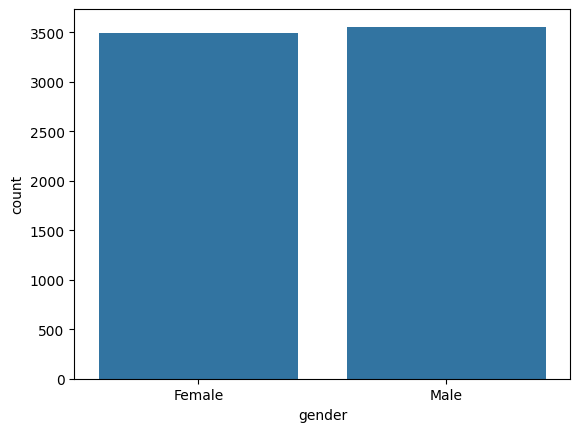

         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################


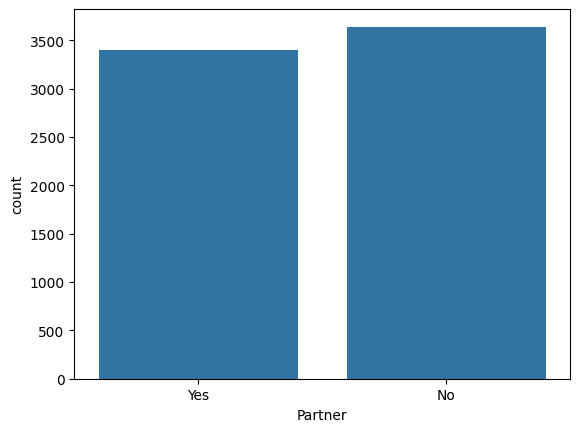

            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################


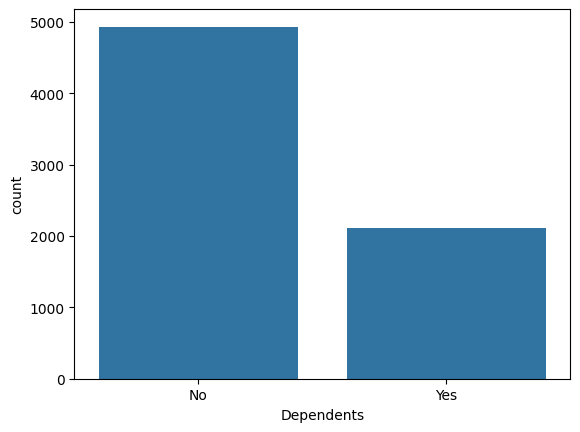

              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################


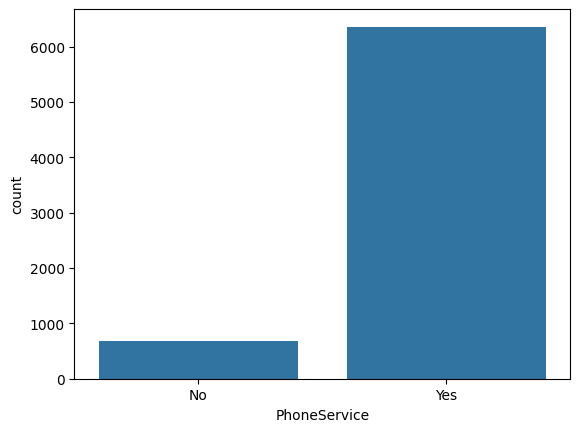

                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################


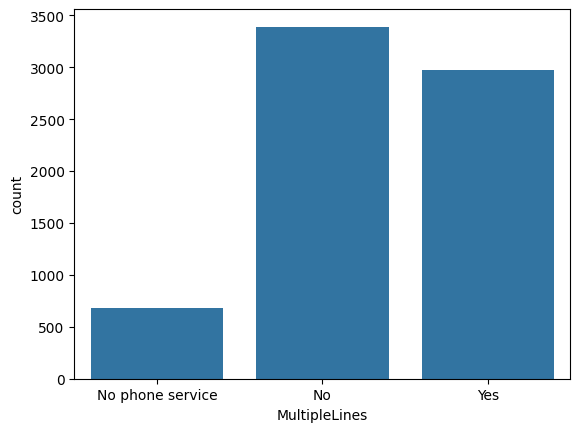

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
##########################################


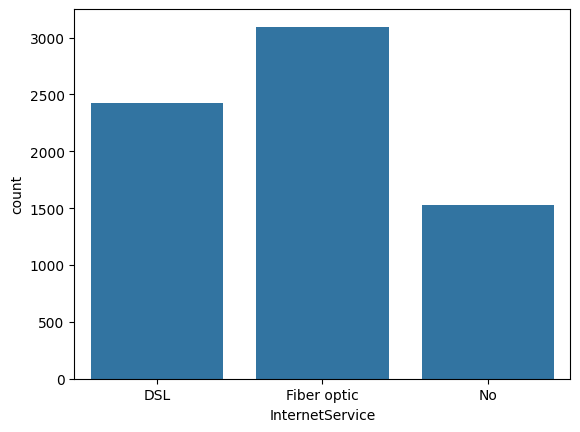

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
##########################################


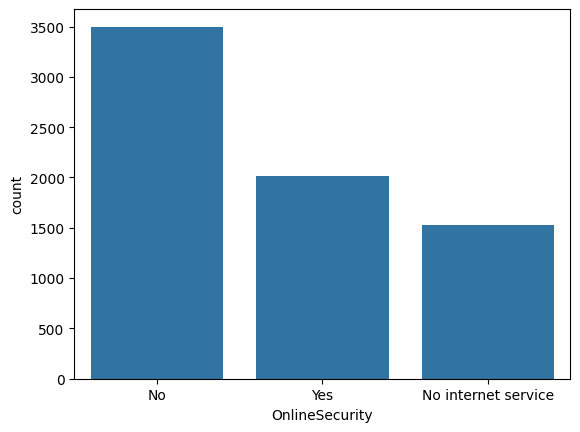

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
##########################################


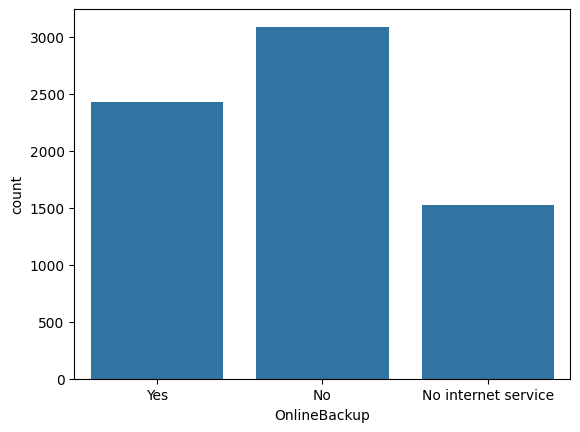

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
##########################################


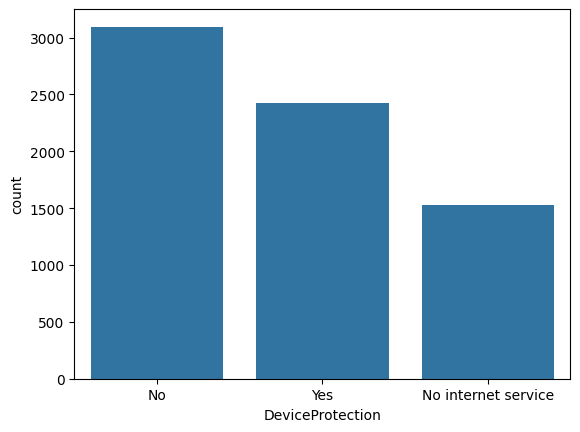

                     TechSupport  Ratio
TechSupport                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
##########################################


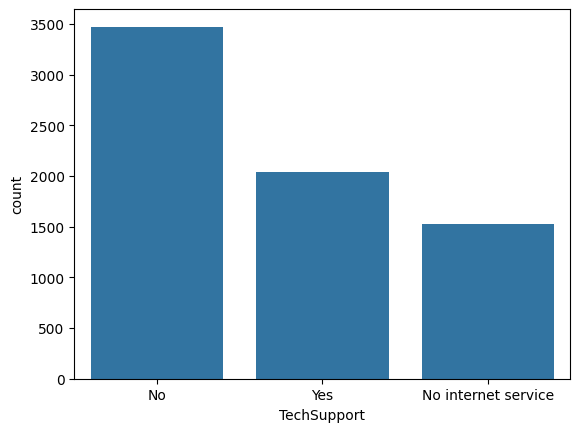

                     StreamingTV  Ratio
StreamingTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
##########################################


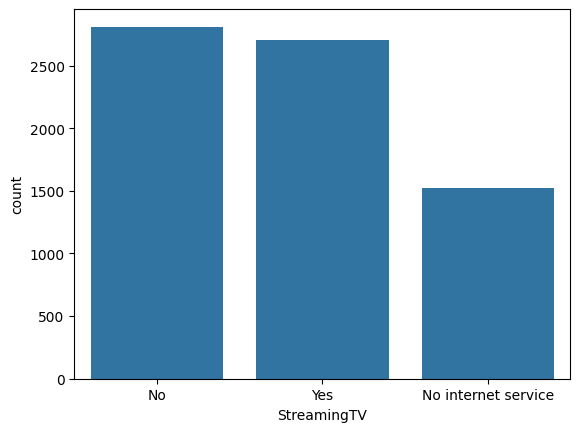

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
##########################################


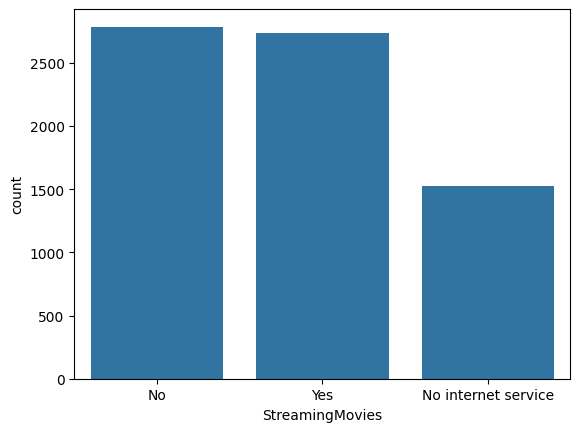

                Contract  Ratio
Contract                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
##########################################


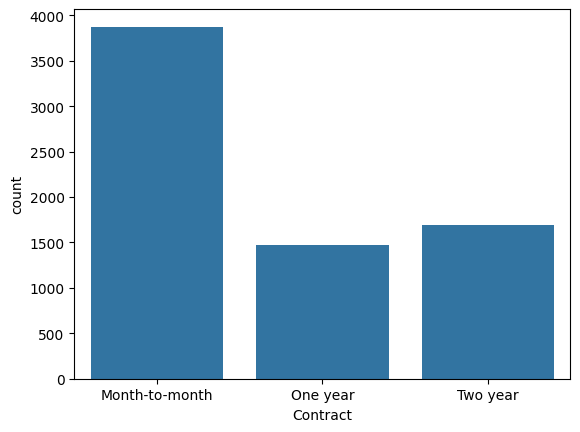

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4171 59.222
No                            2872 40.778
##########################################


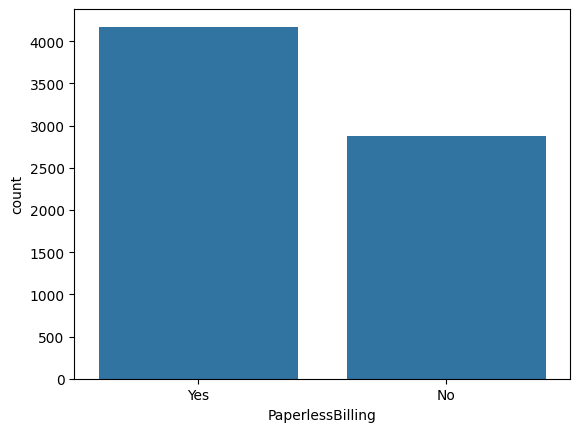

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
##########################################


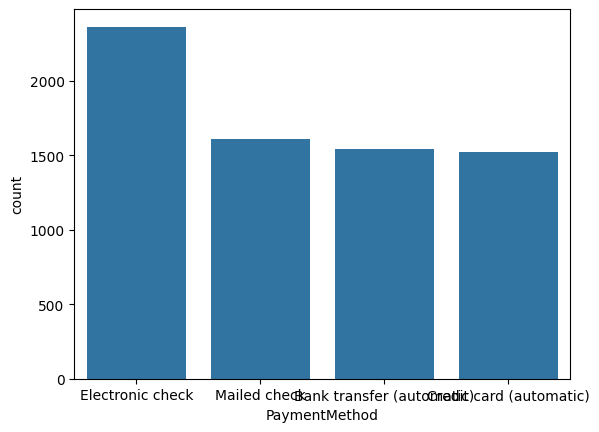

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5901 83.785
1                       1142 16.215
##########################################


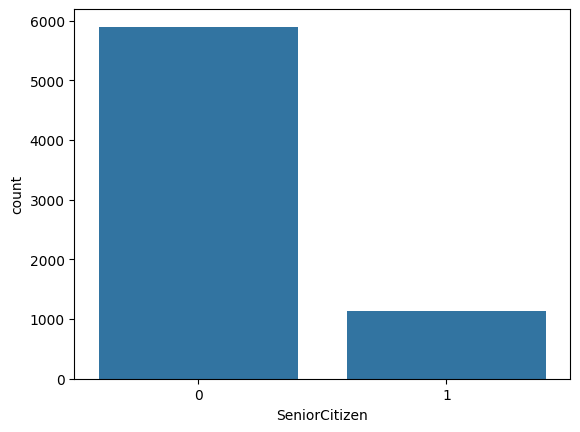

       Churn  Ratio
Churn              
0       5174 73.463
1       1869 26.537
##########################################


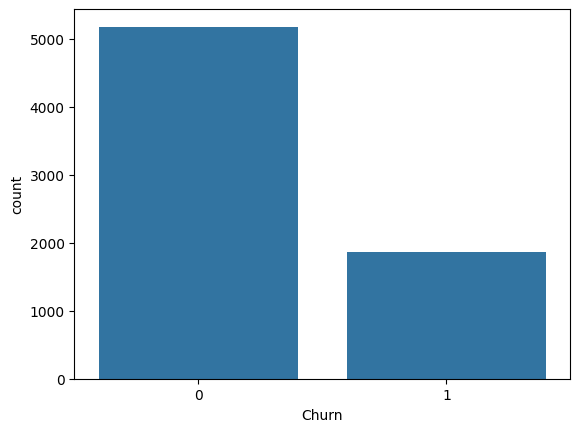

In [9]:
def cat_summary(dataframe, col_name, plot=True):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

### 1.3 ANALYSIS OF NUMERİCAL VARIABLES

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


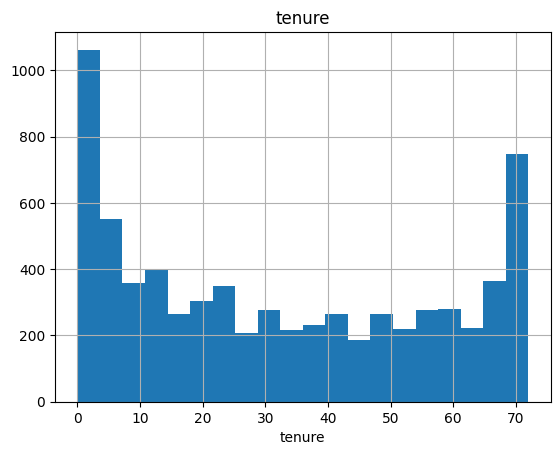

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


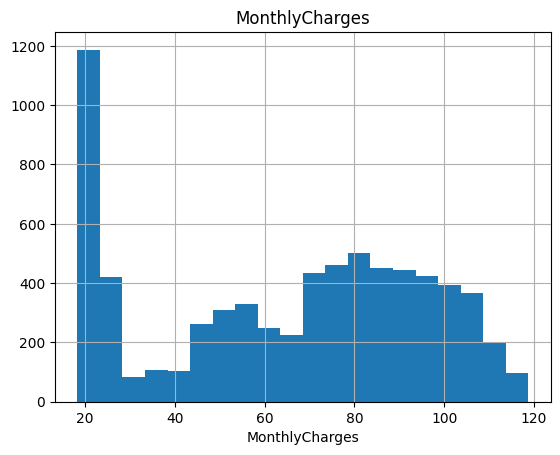

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


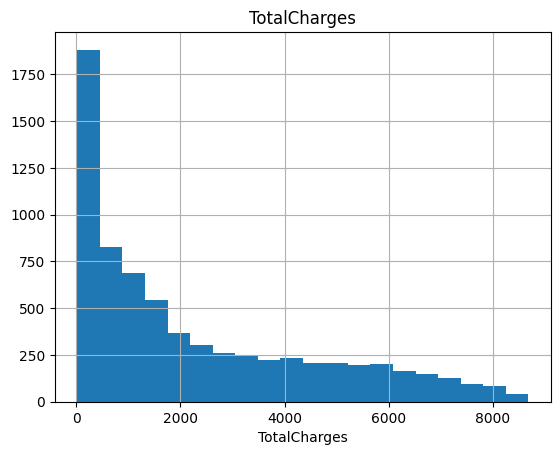

In [10]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

### 1.4 ANALYSIS OF NUMERICAL VARIABLES BY TARGET

In [11]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Churn", col)

# As Tenure increases, Churn Risk decreases.
# Churning customers have more MonthlyCharge. In other words, the higher the bill, the higher the probability of Churn.
# Loyal customers paid more. In other words, we can say that customers who pay more are more loyal customers.

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




### 1.5 ANALYSIS OF CATEGORICAL VARIABLES BY TARGET

In [12]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

plt.figure(figsize=(15, 5))

gender
        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


Dependents
            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


PhoneService
              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


InternetService
                 TARGET_MEAN  Count  Ratio
InternetService                           
DSL                    0.19

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

### 1.6 CORRELATION

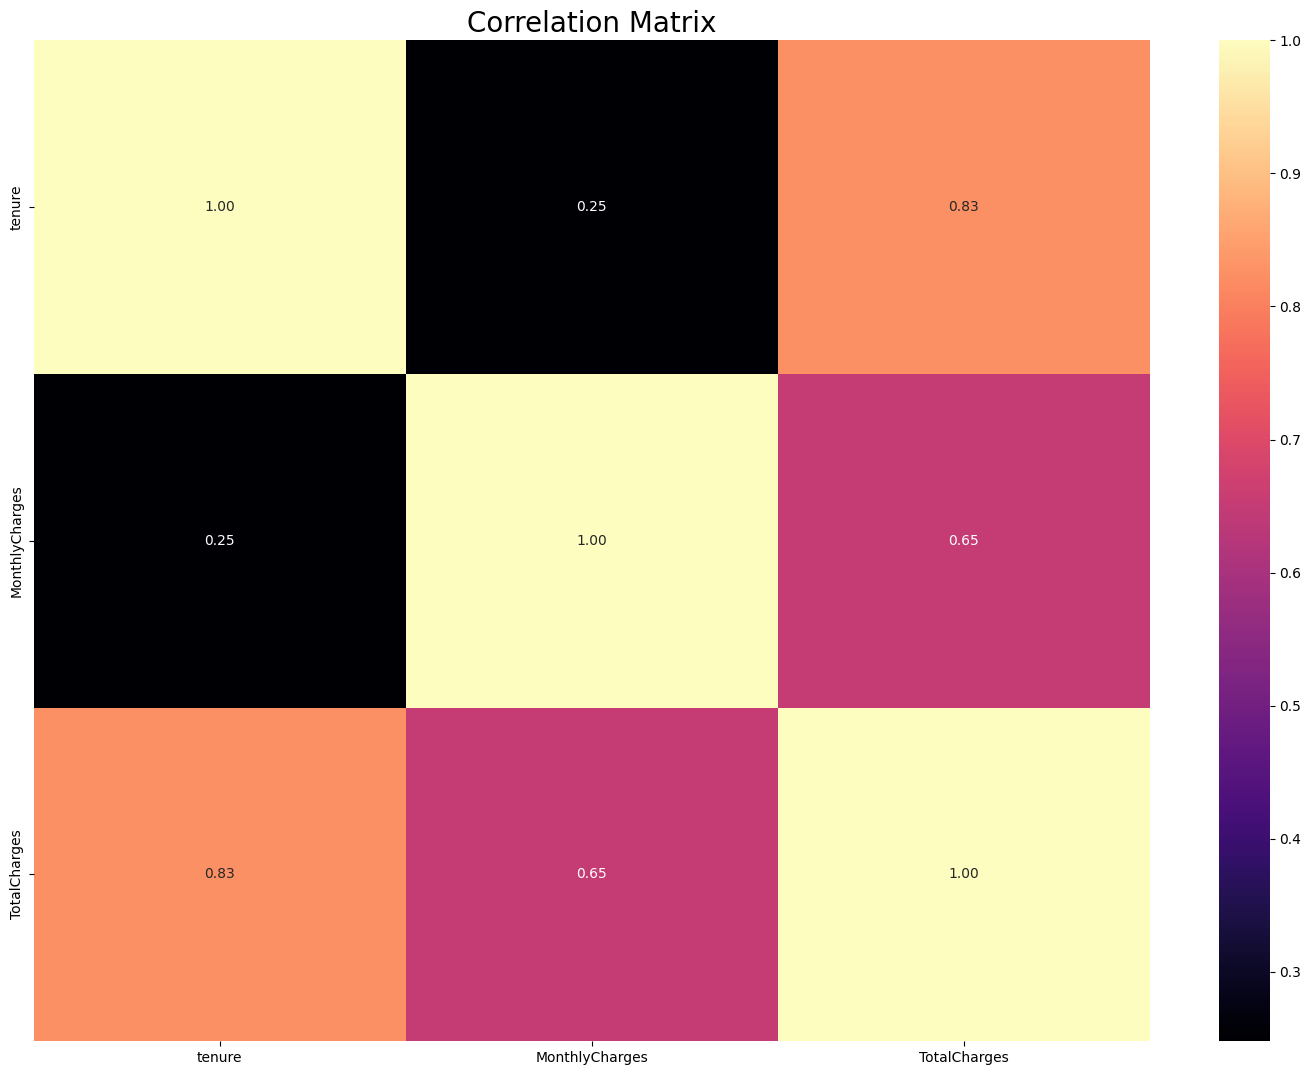

,0
MonthlyCharges,0.193
TotalCharges,-0.199
tenure,-0.352


In [13]:
df[num_cols].corr() # TotalCharges & tenure correlation is 0.825

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

df[num_cols].corrwith(df["Churn"]).sort_values(ascending=False)

## 2. FEATURE ENGINEERING

### 2.1 MISSING VALUE ANALYSİS

In [14]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

              n_miss  ratio
TotalCharges      11  0.160


In [15]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### BASE MODEL

In [16]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
dff = one_hot_encoder(dff, cat_cols, drop_first=True)

y = dff["Churn"]
X = dff.drop(["Churn","customerID"], axis=1)

In [19]:
# All models

models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('SVM', SVC(gamma='auto', random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345, verbose = -1))]


for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

########## LR ##########
Accuracy: 0.8025
Auc: 0.8431
Recall: 0.5367
Precision: 0.6568
F1: 0.5904
########## KNN ##########
Accuracy: 0.7637
Auc: 0.7464
Recall: 0.4462
Precision: 0.5711
F1: 0.5005
########## CART ##########
Accuracy: 0.7277
Auc: 0.6579
Recall: 0.504
Precision: 0.4876
F1: 0.4954
########## RF ##########
Accuracy: 0.792
Auc: 0.8254
Recall: 0.4837
Precision: 0.6451
F1: 0.5526
########## SVM ##########
Accuracy: 0.7696
Auc: 0.7141
Recall: 0.2905
Precision: 0.6495
F1: 0.4009
########## XGB ##########
Accuracy: 0.783
Auc: 0.8243
Recall: 0.5126
Precision: 0.6107
F1: 0.5568
########## LightGBM ##########
Accuracy: 0.7967
Auc: 0.8361
Recall: 0.5297
Precision: 0.6437
F1: 0.5805


### 2.2 OUTLIERS DETECTION & IMPUTATION

In [20]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)


tenure False
MonthlyCharges False
TotalCharges False


### 2.3 FEATURE ENGINEERING

In [21]:
# Creating a yearly categorical variable from the "tenure" feature
df.loc[(df["tenure"] >= 0) & (df["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"] > 12) & (df["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"] > 24) & (df["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"] > 36) & (df["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"] > 48) & (df["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"] > 60) & (df["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

# Labeling customers with 1 or 2-year contracts as "Engaged"
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

# Customers who do not have any backup, protection, or support services
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

# Customers with a monthly contract and who are young
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

# The total number of services received by the customer
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                               'OnlineBackup', 'DeviceProtection', 'TechSupport',
                               'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

# Customers who subscribe to any streaming service
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

# Does the customer make automatic payments?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

# Average monthly payment
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

# Increase of the current price compared to the average price
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

# Fee per service
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)


### 2.4 ENCODING

In [24]:
# Separating variables based on their data types
cat_cols, num_cols, cat_but_car = grab_col_names(df)

# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

# One-Hot Encoding Process
# Updating the cat_cols list
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

Observations: 7043
Variables: 46
cat_cols: 39
num_cols: 6
cat_but_car: 1
num_but_cat: 39


,customerID,tenure,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,gender_1,Partner_1,Dependents_1,PhoneService_1,PaperlessBilling_1,MultipleLines_No phone service_True,MultipleLines_Yes_True,InternetService_Fiber optic_True,InternetService_No_True,OnlineSecurity_No internet service_True,OnlineSecurity_Yes_True,OnlineBackup_No internet service_True,OnlineBackup_Yes_True,DeviceProtection_No internet service_True,DeviceProtection_Yes_True,TechSupport_No internet service_True,TechSupport_Yes_True,StreamingTV_No internet service_True,StreamingTV_Yes_True,StreamingMovies_No internet service_True,StreamingMovies_Yes_True,Contract_One year_True,Contract_Two year_True,PaymentMethod_Credit card (automatic)_True,PaymentMethod_Electronic check_True,PaymentMethod_Mailed check_True,NEW_TENURE_YEAR_1-2 Year_True,NEW_TENURE_YEAR_2-3 Year_True,NEW_TENURE_YEAR_3-4 Year_True,NEW_TENURE_YEAR_4-5 Year_True,NEW_TENURE_YEAR_5-6 Year_True,SeniorCitizen_1_True,NEW_Engaged_1_True,NEW_noProt_1_True,NEW_Young_Not_Engaged_1_True,NEW_FLAG_ANY_STREAMING_1_True,NEW_FLAG_AutoPayment_1_True
0,7590-VHVEG,1,29.850,29.850,0,1,14.925,0.500,14.925,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False
1,5575-GNVDE,34,56.950,1889.500,0,3,53.986,0.948,14.238,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False
2,3668-QPYBK,2,53.850,108.150,1,3,36.050,0.669,13.463,True,False,False,True,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False
3,7795-CFOCW,45,42.300,1840.750,0,3,40.016,0.946,10.575,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True
4,9237-HQITU,2,70.700,151.650,1,1,50.550,0.715,35.350,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False


In [32]:
df["Churn"]

,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1


## ALL MODELS WITH NEW FEATURES

In [33]:
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)

##################################
# PERFORMANCE ANALYSIS WITH BASIC MODELS
##################################

models = [
    ('LR', LogisticRegression(random_state=12345)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=12345)),
    ('RF', RandomForestClassifier(random_state=12345)),
    ('SVM', SVC(gamma='auto', random_state=12345)),
    ('XGB', XGBClassifier(random_state=12345)),
    ('LightGBM', LGBMClassifier(random_state=12345, verbose = -1))
]

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"\n########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"AUC: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1 Score: {round(cv_results['test_f1'].mean(), 4)}")



########## LR ##########
Accuracy: 0.8049
AUC: 0.8454
Recall: 0.5105
Precision: 0.6771
F1 Score: 0.581

########## KNN ##########
Accuracy: 0.7704
AUC: 0.7539
Recall: 0.465
Precision: 0.5862
F1 Score: 0.5177

########## CART ##########
Accuracy: 0.7281
AUC: 0.6584
Recall: 0.5056
Precision: 0.4886
F1 Score: 0.4969

########## RF ##########
Accuracy: 0.7927
AUC: 0.8284
Recall: 0.4955
Precision: 0.6426
F1 Score: 0.5592

########## SVM ##########
Accuracy: 0.7681
AUC: 0.7255
Recall: 0.2579
Precision: 0.6657
F1 Score: 0.3708

########## XGB ##########
Accuracy: 0.7823
AUC: 0.8233
Recall: 0.4992
Precision: 0.6108
F1 Score: 0.5489

########## LightGBM ##########
Accuracy: 0.7974
AUC: 0.8353
Recall: 0.5297
Precision: 0.6448
F1 Score: 0.5814


In [36]:
##################################
# DEFINING HYPERPARAMETER RANGES
##################################

models_params = {
    "RandomForest": (
        RandomForestClassifier(random_state=17),
        {
            "max_depth": np.arange(3, 20),
            "max_features": [3, 5, 7, "auto", "sqrt"],
            "min_samples_split": np.arange(2, 20),
            "n_estimators": np.arange(100, 1000, 50)
        }
    ),
    "XGBoost": (
        XGBClassifier(random_state=17, verbosity=0),
        {
            "learning_rate": [0.1, 0.01, 0.001],
            "max_depth": np.arange(3, 20),
            "n_estimators": np.arange(100, 1000, 50),
            "colsample_bytree": [0.5, 0.7, 1]
        }
    ),
    "LightGBM": (
        LGBMClassifier(random_state=17, verbose = -1),
        {
            "learning_rate": [0.1, 0.01, 0.001],
            "n_estimators": np.arange(100, 1000, 100),
            "colsample_bytree": [0.5, 0.7, 1]
        }
    )

}

In [37]:
##################################
# RANDOMIZED + GRID SEARCH FUNCTION
##################################

def random_and_grid_search(models_params, X, y, random_iter=20, cv_random=3, cv_grid=5, plot_feature_importance=False):
    results = []
    best_params_all = {}
    final_models = {}

    for name, (model, random_param_grid) in models_params.items():
        print(f"\n########## {name} Model Training Started ##########")

        # 1. RandomizedSearchCV stage
        random_search = RandomizedSearchCV(
            model,
            random_param_grid,
            n_iter=random_iter,
            cv=cv_random,
            n_jobs=-1,
            random_state=17,
            verbose=0
        ).fit(X, y)

        print(f"RandomizedSearch Best Params for {name}: {random_search.best_params_}")

        # 2. Preparing parameters for GridSearchCV
        best_params = random_search.best_params_
        grid_param_grid = {}

        for param_name, best_val in best_params.items():
            if isinstance(best_val, (int, float)):
                if param_name in ["learning_rate", "colsample_bytree", "feature_fraction"]:
                    grid_param_grid[param_name] = [
                        max(0.0001, best_val * 0.9),
                        best_val,
                        min(1.0, best_val * 1.1)
                    ]
                else:
                    grid_param_grid[param_name] = [
                        max(1, best_val - 1),
                        best_val,
                        best_val + 1
                    ]
            else:
                grid_param_grid[param_name] = [best_val]

        # 3. GridSearchCV stage
        grid_search = GridSearchCV(
            model,
            grid_param_grid,
            cv=cv_grid,
            n_jobs=-1,
            verbose=0
        ).fit(X, y)

        print(f"GridSearch Best Params for {name}: {grid_search.best_params_}")

        best_params_all[name] = grid_search.best_params_

        # 4. Training the final model with best parameters
        final_model = model.set_params(**grid_search.best_params_, random_state=17).fit(X, y)
        final_models[name] = final_model

        # 5. Cross-validation performance measurement
        cv_results = cross_validate(final_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

        results.append({
            "Model": name,
            "Accuracy": round(cv_results["test_accuracy"].mean(), 4),
            "F1 Score": round(cv_results["test_f1"].mean(), 4),
            "ROC AUC": round(cv_results["test_roc_auc"].mean(), 4)
        })

    # 6. Convert results into a DataFrame
    results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False).reset_index(drop=True)

    # 7. Feature Importance plotting (optional)
    if plot_feature_importance:
        for name, model in final_models.items():
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
                feature_names = X.columns
                feature_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
                feature_imp_df = feature_imp_df.sort_values(by="Importance", ascending=False)

                plt.figure(figsize=(10, 6))
                plt.barh(feature_imp_df["Feature"], feature_imp_df["Importance"], color="royalblue")
                plt.title(f"{name} - Feature Importances", fontsize=16, fontweight="bold")
                plt.gca().invert_yaxis()
                plt.grid(True, axis='x', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
            else:
                print(f"\nNo 'feature_importances_' attribute found for {name} model. (Skipped.)")

    return results_df, best_params_all



########## RandomForest Model Training Started ##########
RandomizedSearch Best Params for RandomForest: {'n_estimators': np.int64(150), 'min_samples_split': np.int64(18), 'max_features': 'sqrt', 'max_depth': np.int64(9)}
GridSearch Best Params for RandomForest: {'max_depth': np.int64(9), 'max_features': 'sqrt', 'min_samples_split': np.int64(18), 'n_estimators': np.int64(150)}

########## XGBoost Model Training Started ##########
RandomizedSearch Best Params for XGBoost: {'n_estimators': np.int64(750), 'max_depth': np.int64(5), 'learning_rate': 0.01, 'colsample_bytree': 1}
GridSearch Best Params for XGBoost: {'colsample_bytree': 0.9, 'learning_rate': 0.011000000000000001, 'max_depth': np.int64(5), 'n_estimators': np.int64(750)}

########## LightGBM Model Training Started ##########
RandomizedSearch Best Params for LightGBM: {'n_estimators': np.int64(400), 'learning_rate': 0.01, 'colsample_bytree': 1}
GridSearch Best Params for LightGBM: {'colsample_bytree': 0.9, 'learning_rate': 0.011

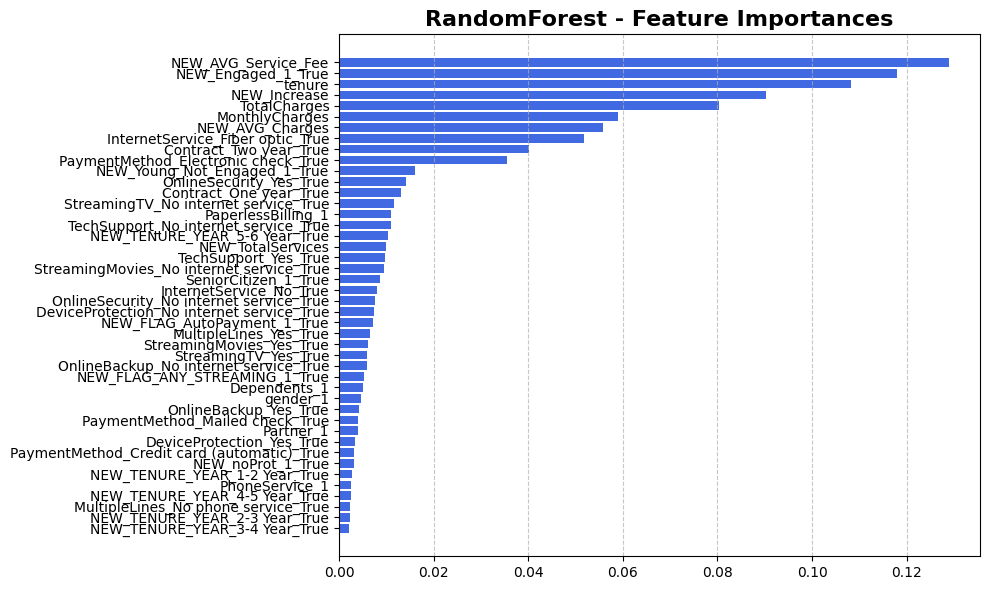

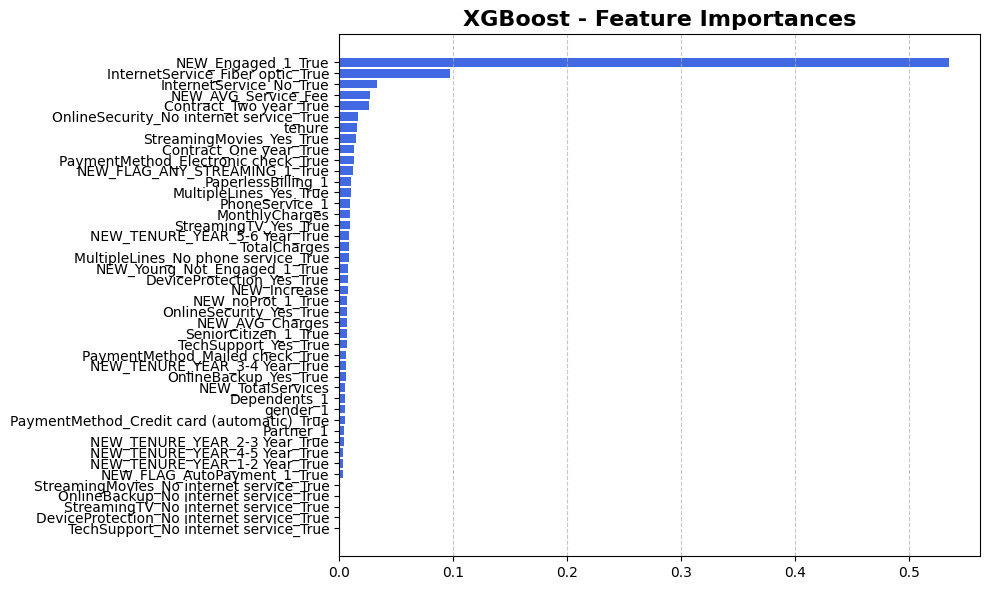

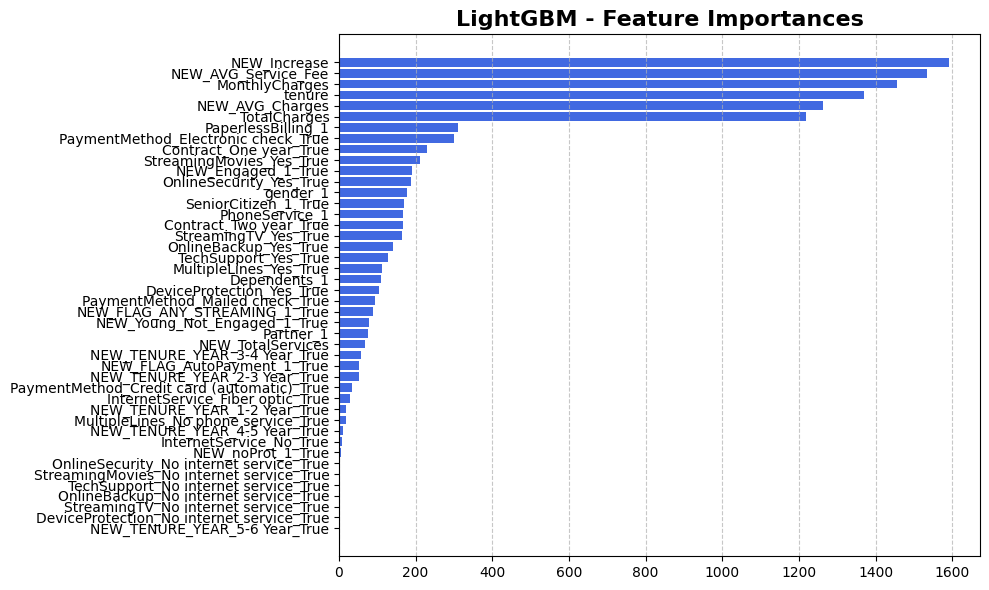


########## Final Model Performances ##########
          Model  Accuracy  F1 Score  ROC AUC
0  RandomForest     0.801     0.576    0.846
1       XGBoost     0.802     0.588    0.844
2      LightGBM     0.801     0.585    0.843

########## Best Hyperparameters ##########
{'RandomForest': {'max_depth': np.int64(9), 'max_features': 'sqrt', 'min_samples_split': np.int64(18), 'n_estimators': np.int64(150)}, 'XGBoost': {'colsample_bytree': 0.9, 'learning_rate': 0.011000000000000001, 'max_depth': np.int64(5), 'n_estimators': np.int64(750)}, 'LightGBM': {'colsample_bytree': 0.9, 'learning_rate': 0.011000000000000001, 'n_estimators': np.int64(400)}}


In [38]:
##################################
# FUNCTION EXECUTION
##################################

results_df, best_params_all = random_and_grid_search(models_params, X, y, plot_feature_importance=True)

# Results
print("\n########## Final Model Performances ##########")
print(results_df)

print("\n########## Best Hyperparameters ##########")
print(best_params_all)